In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Import

In [4]:
import os
import numpy as np
import pandas as pd
import time
import argparse
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

path = "/content/gdrive/My Drive/GameTheory/"

gpu = True
gpu = gpu and torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")

'''hparameters'''
num_classes = 10


learningRate = 0.01
weightDecay = 5e-4

best_acc = 0     # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# CIFAR10 Data
------------------------------------
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [5]:
print('==> Preparing data..')
transformtrain = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transformtest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

"""[-1,1]"""
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transformtrain)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transformtest)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)

attackloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for x,y in trainloader:
    print("Image: ", x[0,0,:,:])
    print("Target: ", y)

Image:  tensor([[-2.4291, -2.4291, -1.0334,  ..., -1.0334, -1.0334, -0.9946],
        [-2.4291, -2.4291, -0.9558,  ..., -0.5681, -0.3936, -0.1804],
        [-2.4291, -2.4291, -0.7620,  ...,  0.5950,  0.6919,  0.7113],
        ...,
        [-2.4291, -2.4291,  0.7307,  ...,  0.7113,  0.6531,  0.4787],
        [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
        [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]])
Target:  tensor([5, 4, 1, 1, 2, 3, 2, 4, 4, 8, 1, 5, 5, 6, 8, 7, 0, 3, 1, 4, 0, 4, 5, 0,
        8, 7, 9, 6, 7, 1, 3, 1, 5, 1, 8, 2, 7, 4, 2, 6, 5, 1, 6, 9, 5, 1, 9, 3,
        0, 0, 9, 9, 6, 9, 1, 9, 9, 1, 6, 9, 4, 1, 4, 6, 5, 0, 7, 1, 6, 7, 4, 1,
        2, 1, 9, 0, 1, 6, 0, 1, 5, 3, 7, 1, 0, 1, 3, 4, 2, 0, 0, 8, 3, 5, 2, 0,
        6, 2, 7, 3, 0, 4, 6, 3, 8, 2, 2, 6, 4, 0, 5, 3, 1, 2, 2, 1, 1, 0, 7, 8,
        1, 3, 3, 6, 3, 5, 6, 6, 8, 2, 2, 7, 0, 0, 1, 8, 7, 1, 3, 3, 0, 8, 5, 3,
        2, 5, 7, 4, 9, 8, 2, 9, 6, 8, 4, 0, 8, 1, 8, 7, 9, 1, 6, 5, 3

KeyboardInterrupt: ignored

# Attack Images Generation
------------------------
batch_size=1

## FGSM
-------------------
epsilon=2/256

In [17]:
# FGSM attack code
"""epsilon=2/256"""

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def fgsm_attack2(image, epsilon, data_grad, mask):
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = torch.mul(data_grad.sign(), mask.view(-1, 1, 1, 1))

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def generate_fgsm_attack(model, test_loader, epsilon):
    '''
    return: attack instance generated, and laebl 
    '''
    
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # mask: 1 for correct, only update grad on correct image
        mask = torch.eq(init_pred.flatten(), target.flatten()).float()

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        # perturbed_data = fgsm_attack2(data, epsilon, data_grad, mask)
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((target.flatten().detach().cpu().numpy(), adv_ex))
        # pred_list.append((init_pred.flatten().detach().cpu().numpy(), final_pred.flatten().detach().cpu().numpy()))
        
    label = [j for i in adv_examples for j in i[0]]
    adv_ex = [j for i in adv_examples for j in i[1]]

    # Return the accuracy and an adversarial example
    return adv_ex, label


class AdvDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.Tensor(data)
        self.label = torch.Tensor(label)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [24]:
adv_ex, label = generate_fgsm_attack(pretrained_model, testloader, 2/256)
attackdataset = AdvDataset(adv_ex, label)
attackloader = torch.utils.data.DataLoader(attackdataset, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
for x,y in attackloader:
    print("Image: ", x)
    print("Target: ", y)

## PGD 
------------------------
eps: maximum distortion of adversarial example compared to original input

eps_iter: step size for each attack iteration

nb_iter: Number of attack iterations.

In [20]:
"""lamda=2"""

def pgd_attack(model, images, labels, eps=0.3, alpha=2/256, iters=5) :
    images = images.to(device)
    labels = labels.to(device)
    # loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

# Model

## others

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


# def ResNet50SAP():
#     return ResNetSAP(BottleneckSAP, [3, 4, 6, 3])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

## Non SAP

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## SAP

In [8]:
import random

class RandomSAP(nn.Module):
    """
    The original paper is https://arxiv.org/abs/1803.01442.
    ----------
    self.is_valid bool : if this flag is True, inject SAP.
    """
    def __init__(self, is_valid=False):
        """
        Parameters
        ----------
        ratio float : ratio of pruning which can be larger than 1.0.
        is_valid bool : if this flag is True, inject SAP.
        """
        super(RandomSAP, self).__init__()
        self.is_valid = is_valid

    def forward(self, inputs):
        """
        If self.training or not self.is_valid, just return inputs.
        If self.is_valid apply SAP to inputs and return the result tensor.
        Parameters
        ----------
        inputs torch.Tensor : input tensor whose shape is [b, c, h, w].
        Returns
        -------
        outputs torch.Tensor : just return inputs or stochastically pruned inputs.
        """
        if not self.is_valid:
            return inputs
        else:
            b, c, h, w = inputs.shape   # (batchsize, channelsize, imagesize)
            inputs_1d = inputs.reshape([b, c * h * w])  # [b, c * h * w]
            # inputs_len = len(inputs_1d)  # = b
            
            # torch.manual_seed(10)
            drop_prob = torch.rand(inputs_1d.shape, dtype=torch.float64)
            drop_node = torch.where(drop_node>0.5, drop_node, 0.)
            drop_node = torch.DoubleTensor(drop_node).float().cuda() 
            outputs = drop_node.reshape([b, c, h, w])  # [b, c, h, w]

        return outputs

In [ ]:
p = torch.rand((100,3*32*32), dtype=torch.float64)
q=p.reshape([100,3,32,32])
q[0,0,:,:].shape

torch.Size([32, 32])

In [9]:
from torch.distributions.multinomial import Multinomial

class SAP(nn.Module):
    """SimpleModel represents a nn.Module of Stochastic Activation Pruning.
    The original paper is https://arxiv.org/abs/1803.01442.
    Attributes
    ----------
    self.ratio float : ratio of pruning which can be larger than 1.0.
    self.is_valid bool : if this flag is True, inject SAP.
    """
    def __init__(self, ratio=1, is_valid=False):
        """
        Parameters
        ----------
        ratio float : ratio of pruning which can be larger than 1.0.
        is_valid bool : if this flag is True, inject SAP.
        """
        super(SAP, self).__init__()
        self.ratio = ratio
        self.is_valid = is_valid

    def forward(self, inputs):
        """
        If self.training or not self.is_valid, just return inputs.
        If self.is_valid apply SAP to inputs and return the result tensor.
        Parameters
        ----------
        inputs torch.Tensor : input tensor whose shape is [b, c, h, w].
        Returns
        -------
        outputs torch.Tensor : just return inputs or stochastically pruned inputs.
        """
        # print("SAP: ", self.is_valid)
        # if self.training or not self.is_valid:
        if not self.is_valid:
            return inputs
        else:
            b, c, h, w = inputs.shape
            inputs_1d = inputs.reshape([b, c * h * w])  # [b, c * h * w]
            # print(inputs_1d)
            outputs = torch.zeros_like(inputs_1d)  # outputs with 0 initilization
           
            inputs_1d_sum = torch.sum(torch.abs(inputs_1d), dim=-1, keepdim=True)
            inputs_1d_prob = torch.abs(inputs_1d) / inputs_1d_sum
            
            # r: num_nodes
            num_sample = int(c * h * w * self.ratio)  

            # multinomial(total_count:int, probs:tensor, logits:tensor)
            idx = Multinomial(num_sample, inputs_1d_prob).sample()

            # if nonzero, keep; else, drop, let be zeroes
            outputs[idx.nonzero(as_tuple=True)] = inputs_1d[idx.nonzero(as_tuple=True)]

            # pdb.set_trace()
            # scale up
            outputs = outputs / (1 - (1-inputs_1d_prob)**num_sample + 1e-12)
            outputs = outputs.reshape([b, c, h, w])  # [b, c, h, w]
            # print("OUT: ", outputs)
        return outputs

In [ ]:
idx = Multinomial(3, Variable(torch.Tensor([0.5,0.4,0.1]))).sample()
print(idx)
idx.nonzero(as_tuple=True)

tensor([2., 1., 0.])


(tensor([0, 1]),)

In [10]:
class BasicBlockSAP(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_valid=False):
        super(BasicBlockSAP, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

        self.sap1 = SAP(is_valid=is_valid)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.sap1(out)
        return out

In [11]:
class ResNetSAP(nn.Module):
    """Model represents a model mainly used in experiments.
    Attributes
    ----------
    self.num_classes int : number of classes of dataset.
    self.layers nn.ModuleDict : ModuleDict of models.
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetSAP, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # self.sap = SAP(is_valid)
        # self.sap1 = nn.Dropout(0.5)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, is_valid=True)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, is_valid=False):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, is_valid))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # out = self.sap(out, batch_idx)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [12]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
        
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet18SAP():
    return ResNetSAP(BasicBlockSAP, [2, 2, 2, 2])

# Free-Training

In [13]:
def train(net, epoch, trainloader):
    net.train()

    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        torch.cuda.empty_cache()
        del inputs
        del targets

    acc = correct/total
    avg_loss = train_loss/total
    
    return avg_loss, acc


def test(net, testloader):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            torch.cuda.empty_cache()
            del inputs
            del targets
            
    acc = correct/total
    avg_loss = test_loss/total
    
    return avg_loss, acc

# Adv-training

## FGSM

In [14]:
def fgsm_train(net, epoch, trainloader, eps=2/255):
    print('\nEpoch: %d' % epoch)
    net.train()

    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs.requires_grad = True

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        data_grad = inputs.grad.data
        perturbed_data = fgsm_attack(inputs, eps, data_grad)
        new_outputs = net(perturbed_data)
        new_loss = criterion(new_outputs, targets)
        new_loss.backward()
        
        optimizer.step()

        train_loss += new_loss.item()
        _, new_predicted = new_outputs.max(1)
        total += targets.size(0)
        correct += new_predicted.eq(targets).sum().item()
        
        torch.cuda.empty_cache()
        del inputs
        del targets

        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    acc = correct/total
    avg_loss = train_loss/total
    
    return avg_loss, acc

## PGD

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
std = torch.tensor(cifar10_std).view(3,1,1).cuda()

upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)

epsilon = (2/256.) / std

step_size = 2

iters = 5

In [51]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

# Training
def pgd_train(model, epoch, epsilon):
    # start_train_time = time.time()

    # logger.info('Epoch \t Seconds \t LR \t \t Train Loss \t Train Acc')

# for epoch in range(args.epochs):
# for epoch in range(start_epoch, start_epoch+20):
    start_epoch_time = time.time()
    
    train_loss = 0
    train_acc = 0
    train_n = 0

    for i, (X, y) in enumerate(trainloader):
        X, y = X.cuda(), y.cuda()
        delta = torch.zeros_like(X).cuda()

        # if args.delta_init == 'random':
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit-X, upper_limit-X)

        delta.requires_grad = True
        for _ in range(iters):
            output = model(X + delta)
            loss = criterion(output, y)

            # with amp.scale_loss(loss, optimizer) as scaled_loss:
            loss.backward()
            
            grad = delta.grad.detach()
            delta.data = clamp(delta + step_size*torch.sign(grad), -epsilon, epsilon)
            delta.data = clamp(delta, lower_limit-X, upper_limit-X)
            delta.grad.zero_()
        
        delta = delta.detach()
        output = model(X + delta)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        # with amp.scale_loss(loss, optimizer) as scaled_loss:
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
        
        # scheduler.step()
    epoch_time = time.time()
    # lr = scheduler.get_lr()[0]
    # logger.info('%d \t %.1f \t \t %.4f \t %.4f \t %.4f',
    #             epoch, epoch_time-start_epoch_time, train_loss/train_n, train_acc/train_n)
    
    print(epoch_time-start_epoch_time)
    return train_loss/train_n, train_acc/train_n

#Confusion Matrix

In [ ]:
"""batch=1"""

def get_matrix(net, testloader):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    
    matrix = np.zeros((10,10))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            matrix[targets.detach().cpu().numpy(),predicted.detach().cpu().numpy()] += 1


            torch.cuda.empty_cache()
            del inputs
            del targets
            
    acc = correct/total
    avg_loss = test_loss/total
    
    return avg_loss, acc, matrix

In [ ]:
import pandas as pd
import csv

%cd /content/gdrive/"My Drive"/GameTheory/

def write_matrix(matrix, filename):
    with open(filename, "w", newline='') as f:
        file = csv.writer(f, delimiter=',')
        file.writerow(["target", "predict"])
        for i, row in enumerate(matrix):
            file.writerow([i, row])

/content/gdrive/My Drive/GameTheory


In [ ]:
get_matrix(pretrained_model, attack_loader)

(0.44698605006911973,
 0.8611,
 array([[793.,   7.,  29.,  68.,  12.,   4.,  29.,   1.,  42.,  15.],
        [  4., 904.,   2.,  12.,   0.,   4.,   4.,   0.,   4.,  66.],
        [ 13.,   0., 787.,  84.,  25.,  40.,  40.,   5.,   3.,   3.],
        [  3.,   1.,  16., 864.,   6.,  77.,  29.,   0.,   2.,   2.],
        [  2.,   0.,  20.,  73., 847.,  37.,  16.,   5.,   0.,   0.],
        [  1.,   0.,   7., 143.,   8., 828.,   7.,   3.,   1.,   2.],
        [  1.,   0.,  11.,  47.,   5.,  13., 919.,   1.,   3.,   0.],
        [  3.,   0.,   6.,  99.,  20.,  89.,   4., 775.,   1.,   3.],
        [  8.,   2.,   1.,  20.,   1.,   4.,   4.,   0., 940.,  20.],
        [  5.,  12.,   1.,  16.,   0.,   1.,   3.,   0.,   8., 954.]]))

In [ ]:
get_matrix(confusemodel, attack_loader)

(0.644896176486921,
 0.8175,
 array([[813.,   1.,  14.,  20.,   3.,   2.,   2.,   9.,  79.,  57.],
        [  4., 858.,   1.,   3.,   0.,   3.,   0.,   0.,  31., 100.],
        [ 55.,   2., 750.,  58.,  29.,  45.,   8.,  20.,  24.,   9.],
        [ 16.,   4.,  28., 676.,  12., 144.,  14.,  34.,  40.,  32.],
        [ 13.,   1.,  46.,  66., 731.,  29.,   7.,  75.,  18.,  14.],
        [  9.,   1.,  17.,  99.,   9., 802.,   3.,  31.,  10.,  19.],
        [  5.,   1.,  47.,  83.,  18.,  42., 742.,   4.,  28.,  30.],
        [  7.,   0.,  15.,  14.,   9.,  24.,   0., 910.,  10.,  11.],
        [ 11.,   1.,   4.,   4.,   0.,   3.,   0.,   0., 958.,  19.],
        [  6.,  21.,   3.,   3.,   0.,   1.,   0.,   2.,  29., 935.]]))

In [ ]:
import gc

del confusemodel

gc.collect()

torch.cuda.empty_cache()

In [ ]:
criterion = nn.CrossEntropyLoss()
modelpath = path + "ResNet18_19.pth"
# /content/gdrive/MyDrive/GameTheory/Adc_ResNet50_19.pth
confusemodel = ResNet18().to(device)
confusemodel.load_state_dict(torch.load(modelpath)['model_state_dict'])
pretrained_dict = confusemodel.state_dict()
# confusemodel

In [ ]:
loss,acc,m = get_matrix(confusemodel, attack_loader)

In [ ]:
write_matrix(m, "ResNet18_20epoch.csv")

# Gradients

In [ ]:
def get_grad(model, test_loader):
    '''
    return: Gradient of image, num_imgs x channel x w x h,
    10000 x 3 x 32 x 32
    '''
    grad_list = []
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        grad_list.append(data_grad.detach().cpu().numpy())

        del data, target, data_grad, output
    
    torch.cuda.empty_cache()
    return np.concatenate(grad_list)

# Attack

## Grey-box

In [43]:
def grey_box_attack(model, attack_loader):
    '''
    attack_loader: dataloader of attack instance generated by resnet18 free-trained model
    '''

    model.eval()

    correct = 0.
    for data, target in attack_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Forward pass the data through the model
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print("predict: ", pred.detach().cpu().numpy(), target.detach().cpu().numpy())
        # Zero all existing gradients
        model.zero_grad()

        # calculate correct prediction
        correct += torch.sum(torch.eq(pred.flatten(), target.flatten())).item()
        # Special case for saving 0 epsilon examples

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(attack_loader))

    # print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testloader), acc))
    # Return the accuracy and an adversarial example
    return final_acc

## Non SAP

In [ ]:
"""
perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
"""

def testattack(net, testloader, epsilon):
    # global best_acc
    net.eval()

    # test_loss = 0
    correct = 0
    # total = 0
    # with torch.no_grad():
    for b, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs, targets = Variable(inputs), Variable(targets)-1
        
        inputs.requires_grad = True
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        # if predicted.item() != targets.item():
        #     continue
        loss = criterion(outputs, targets)
        net.zero_grad()

        # test_loss += loss.item()
        loss.backward()
        data_grad = inputs.grad.data
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
        new_outputs = net(perturbed_data)
        _, new_predicted = new_outputs.max(1)

        # total += targets.size(0)
        correct += new_predicted.eq(targets).sum().item()

        torch.cuda.empty_cache()
        del inputs
        del targets
        
    acc = correct/float(len(testloader))
    # avg_loss = test_loss/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testloader), acc))

    return acc

## SAP

In [ ]:
import pdb
import time
def testattackSAP(net, net_sap, testloader, epsilon):
    # global best_acc
    net.eval()

    # test_loss = 0
    correct = 0.
    correct_sap = 0.
    # total = 0
    # with torch.no_grad():
    nonsap = []
    nonsap_att = []
    sap = []
    sap_att = []
    ytrue = []
    
    start = time.time()
    for b, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs, targets = Variable(inputs), Variable(targets)-1
        
        inputs.requires_grad = True

        outputs = net(inputs)
        outputs_sap = net_sap(inputs)
        # nonsap.append(outputs.detach().cpu().numpy())
        # sap.append(outputs_sap.detach().cpu().numpy())
        # print("[non sap]: ",outputs, "\n[sap]: ", outputs_sap, "\n")
        
        _, predicted = outputs.max(1)
        _, predicted_sap = outputs_sap.max(1)
        # if predicted.item() != targets.item():
        #     continue
        loss = criterion(outputs, targets)
        # loss_sap = criterion(outputs_sap, targets)

        net.zero_grad()
        # net_sap.zero_grad()

        # test_loss += loss.item()
        loss.backward()
        # loss_sap.backward()

        # pdb.set_trace()
        data_grad = inputs.grad.data
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
        
        new_outputs = net(perturbed_data)
        _, new_predicted = new_outputs.max(1)
        new_outputs_sap = net_sap(perturbed_data)
        _, new_predicted_sap = new_outputs_sap.max(1)

        # print("nonsap: ", new_predicted)
        # print("sap: ", new_predicted_sap, "\n")
        nonsap.append(predicted.detach().cpu().numpy())
        nonsap_att.append(new_predicted.detach().cpu().numpy())
        sap.append(predicted_sap.detach().cpu().numpy())
        sap_att.append(new_predicted_sap.detach().cpu().numpy())
        ytrue.append(targets.detach().cpu().numpy())
        # total += targets.size(0)
        # correct += torch.sum(torch.eq(pred.flatten(), targets.flatten())).item()
        correct += new_predicted.eq(targets).sum().item()
        correct_sap += new_predicted_sap.eq(targets).sum().item()

        torch.cuda.empty_cache()
        del inputs
        del targets
        
    acc = correct / float(len(testloader))
    acc_sap = correct_sap / float(len(testloader))
    # avg_loss = test_loss/total
    print("Time: ", time.time()-start)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testloader), acc))
    print("Epsilon: {}\tSAP Test Accuracy = {} / {} = {}".format(epsilon, correct_sap, len(testloader), acc_sap))

    return acc,acc_sap,nonsap,nonsap_att,sap,sap_att,ytrue

## Multi-SAP


In [ ]:
def testattackMultiSAP(net, net_sap, testloader, epsilon):
    # global best_acc
    net.eval()

    # test_loss = 0
    # correct = 0.
    correct_sap = 0.
    # total = 0
    # with torch.no_grad():
    # nonsap = []
    sap = []
    ytrue = []
    
    start = time.time()
    for b, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs, targets = Variable(inputs), Variable(targets)-1
        
        inputs.requires_grad = True

        # outputs = net(inputs)

        for i in range(10):
            outputs_sap = net_sap(inputs)
        # nonsap.append(outputs.detach().cpu().numpy())
        # sap.append(outputs_sap.detach().cpu().numpy())
        # print("[non sap]: ",outputs, "\n[sap]: ", outputs_sap, "\n")
        
        # _, predicted = outputs.max(1)
        _, predicted_sap = outputs_sap.max(1)
        # if predicted.item() != targets.item():
        #     continue
        # loss = criterion(outputs, targets)
        loss_sap = criterion(outputs_sap, targets)

        # net.zero_grad()
        net_sap.zero_grad()

        # test_loss += loss.item()
        # loss.backward()
        loss_sap.backward()

        # pdb.set_trace()
        data_grad = inputs.grad.data
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
        
        # new_outputs = net(perturbed_data)
        # _, new_predicted = new_outputs.max(1)
        new_outputs_sap = net_sap(perturbed_data)
        _, new_predicted_sap = new_outputs_sap.max(1)

        # print("nonsap: ", new_predicted)
        # print("sap: ", new_predicted_sap, "\n")
        # nonsap.append(new_predicted.detach().cpu().numpy())
        sap.append(new_predicted_sap.detach().cpu().numpy())
        ytrue.append(targets.detach().cpu().numpy())
        # total += targets.size(0)
        # correct += torch.sum(torch.eq(pred.flatten(), targets.flatten())).item()
        correct += new_predicted.eq(targets).sum().item()
        correct_sap += new_predicted_sap.eq(targets).sum().item()

        torch.cuda.empty_cache()
        del inputs
        del targets
        
    acc = correct / float(len(testloader))
    acc_sap = correct_sap / float(len(testloader))
    # avg_loss = test_loss/total
    print("Time: ", time.time()-start)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testloader), acc))
    print("Epsilon: {}\tSAP Test Accuracy = {} / {} = {}".format(epsilon, correct_sap, len(testloader), acc_sap))

    return acc,nonsap,sap,ytrue

# Main

In [ ]:
import gc

del resmodel

gc.collect()

torch.cuda.empty_cache()

In [ ]:
"""ResNet18 Model"""
resmodel = ResNet18().to(device)
resmodel.apply(init_weights)

if device == 'cuda':
    resmodel = torch.nn.DataParallel(resmodel)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resmodel.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)

## FGSM train
----------------------
lamda=2, epsilon=2/256

In [ ]:
for epoch in range(start_epoch, start_epoch+30):
    if epoch > 0:
        train_loss, train_acc = train(resmodel, epoch, trainloader)
        adv_train_loss, adv_train_acc = fgsm_train(resmodel, epoch, trainloader)
    val_loss, val_acc = test(resmodel, testloader)
    
    print('[Epoch: {}]\nTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\tAdv_Train Loss: {:.4f}\tAdv_Train Accuracy: {:.4f}\nVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
          format(epoch, train_loss, train_acc, adv_train_loss, adv_train_acc, val_loss, val_acc))
    
    if (epoch+1)%10 == 0:
        torch.save({'model_state_dict': resmodel.state_dict(),},
                    path + "Adv_ResNet18_lamda2_{}.pth".format(str(epoch+1)))

[Epoch: 0]
Train Loss: 0.0116	Train Accuracy: 0.4614	Adv_Train Loss: 0.0095	Adv_Train Accuracy: 0.5643
Val Loss: 0.0102	Val Accuracy: 0.6587

Epoch: 1
[Epoch: 1]
Train Loss: 0.0057	Train Accuracy: 0.7434	Adv_Train Loss: 0.0068	Adv_Train Accuracy: 0.6887
Val Loss: 0.0067	Val Accuracy: 0.7707

Epoch: 2
[Epoch: 2]
Train Loss: 0.0041	Train Accuracy: 0.8167	Adv_Train Loss: 0.0057	Adv_Train Accuracy: 0.7404
Val Loss: 0.0061	Val Accuracy: 0.7941

Epoch: 3
[Epoch: 3]
Train Loss: 0.0033	Train Accuracy: 0.8528	Adv_Train Loss: 0.0049	Adv_Train Accuracy: 0.7767
Val Loss: 0.0050	Val Accuracy: 0.8320

Epoch: 4
[Epoch: 4]
Train Loss: 0.0028	Train Accuracy: 0.8752	Adv_Train Loss: 0.0045	Adv_Train Accuracy: 0.7953
Val Loss: 0.0047	Val Accuracy: 0.8414

Epoch: 5
[Epoch: 5]
Train Loss: 0.0024	Train Accuracy: 0.8953	Adv_Train Loss: 0.0041	Adv_Train Accuracy: 0.8110
Val Loss: 0.0041	Val Accuracy: 0.8564

Epoch: 6
[Epoch: 6]
Train Loss: 0.0020	Train Accuracy: 0.9101	Adv_Train Loss: 0.0037	Adv_Train Accuracy

KeyboardInterrupt: ignored

In [ ]:
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))
print(test(adv_SAPmodel, testloader))

(0.0016541476011276246, 0.859)
(0.0016474242001771927, 0.8585)
(0.6145823064655066, 0.8598)
(0.12422410302460193, 0.8581)
(0.001650982853770256, 0.8593)
(0.7666920542359352, 0.8595)
(0.620114592730999, 0.859)
(0.79029809717834, 0.8578)
(0.0016540011316537857, 0.8587)
(0.0016534852355718612, 0.8586)


In [ ]:
print(test(pretrained_adv_model, testloader))
print(test(pretrained_adv_model, testloader))
print(test(pretrained_adv_model, testloader))

(0.0016444464325904846, 0.8596)
(0.0016444464325904846, 0.8596)
(0.0016444464325904846, 0.8596)


In [ ]:
def test_advtrain_ave(model, loader, num):
    start = time.time()
    res = 0
    for _ in range(num):
        acc = test(model, loader)[1]
        res += acc
    print("Time: ", (time.time()-start)/60, " min")
    return res/num

In [ ]:
test_advtrain_ave(adv_SAPmodel, testloader, 50)

Time:  158.564519405365


0.8589379999999998

## PGD train
-----------------
lamda=2, epsilon=2/256

In [ ]:
for epoch in range(start_epoch, start_epoch+30):
    if epoch > 0:
        train_loss, train_acc = train(resmodel, epoch, trainloader)
        adv_train_loss, adv_train_acc = fgsm_train(resmodel, epoch, trainloader)
    val_loss, val_acc = test(resmodel, testloader)
    
    print('[Epoch: {}]\nTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\tAdv_Train Loss: {:.4f}\tAdv_Train Accuracy: {:.4f}\nVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
          format(epoch, train_loss, train_acc, adv_train_loss, adv_train_acc, val_loss, val_acc))
    
    if (epoch+1)%10 == 0:
        torch.save({'model_state_dict': resmodel.state_dict(),},
                    path + "Adv_ResNet18_lamda2_{}.pth".format(str(epoch+1)))

## free train

In [ ]:
"""res18"""
for epoch in range(start_epoch, start_epoch+20):
    train_loss, train_acc = train(resmodel, epoch, trainloader)
    val_loss, val_acc = test(resmodel, testloader)
    
    print('[Epoch: {}]\nTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
          format(epoch, train_loss, train_acc, val_loss, val_acc))
    
    # if (epoch+1)%10 == 0:
torch.save({'model_state_dict': resmodel.state_dict(),},
            path + "ResNet18_{}.pth".format(str(epoch)))

[Epoch: 0]
Train Loss: 0.0117	Train Accuracy: 0.4587	Val Loss: 0.0114	Val Accuracy: 0.5939
[Epoch: 1]
Train Loss: 0.0079	Train Accuracy: 0.6416	Val Loss: 0.0086	Val Accuracy: 0.7051
[Epoch: 2]
Train Loss: 0.0060	Train Accuracy: 0.7316	Val Loss: 0.0079	Val Accuracy: 0.7331
[Epoch: 3]
Train Loss: 0.0051	Train Accuracy: 0.7759	Val Loss: 0.0067	Val Accuracy: 0.7728
[Epoch: 4]
Train Loss: 0.0044	Train Accuracy: 0.8049	Val Loss: 0.0061	Val Accuracy: 0.7939
[Epoch: 5]
Train Loss: 0.0040	Train Accuracy: 0.8249	Val Loss: 0.0057	Val Accuracy: 0.8102
[Epoch: 6]
Train Loss: 0.0036	Train Accuracy: 0.8408	Val Loss: 0.0064	Val Accuracy: 0.7813
[Epoch: 7]
Train Loss: 0.0033	Train Accuracy: 0.8523	Val Loss: 0.0055	Val Accuracy: 0.8221
[Epoch: 8]
Train Loss: 0.0031	Train Accuracy: 0.8638	Val Loss: 0.0053	Val Accuracy: 0.8255
[Epoch: 9]
Train Loss: 0.0028	Train Accuracy: 0.8776	Val Loss: 0.0042	Val Accuracy: 0.8604
[Epoch: 10]
Train Loss: 0.0026	Train Accuracy: 0.8857	Val Loss: 0.0050	Val Accuracy: 0.834

In [ ]:
test(pretrained_model, test_loader)

(0.004469860792160035, 0.8611)

In [ ]:
"""SR=0.5"""

print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))

(0.8944965143874287, 0.8583)
(0.00452370632737875, 0.8576)
(0.00458715205937624, 0.8572)
(0.004558853530883789, 0.8572)
(0.004578429365158081, 0.8572)
(0.004581910389661789, 0.8594)
(0.8664808819293975, 0.8616)
(1.0704037603110075, 0.8585)
(0.004622278305888176, 0.8571)
(4.022294025121629, 0.8575)


In [ ]:
"""SR=1.0"""

print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))
print(test(random_SAPmodel, test_loader))

(0.004494994308054447, 0.8612)
(0.004496954369544983, 0.8614)
(0.2785295968860388, 0.8622)
(1.2417830664888023, 0.8614)
(2.5826977334246037, 0.861)
(0.8117450577914714, 0.8616)
(1.8044049466073513, 0.8595)
(0.4038210396885872, 0.8611)
(1.8679141411155462, 0.8593)
(2.9259993530392645, 0.8606)


In [ ]:
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))
print(test(SAPmodel, testloader))

(0.0018000679969787598, 0.8598)
(0.9980230608344078, 0.8614)
(0.0018031158626079559, 0.8619)
(0.4121579894781113, 0.8592)
(0.26251333041787145, 0.8614)
(0.8675065795212984, 0.8617)
(0.5413997900575399, 0.8597)
(0.699838333427906, 0.8612)
(0.0018014807403087616, 0.8591)
(2.0190218213915827, 0.8614)


In [ ]:
"""SR=1.5"""

print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))
print(test(SAPmodel, test_loader))

(2.554444275380671, 0.8602)
(0.00448872260004282, 0.8619)
(2.445396376658976, 0.8604)
(0.643435568998754, 0.8615)
(0.004490852276980877, 0.8608)
(3.446573572279513, 0.8628)
(5.070572819425165, 0.8608)
(0.6324783335939049, 0.8605)
(0.004473456868529319, 0.8628)
(0.6166414135754108, 0.8619)


# Reload

## adv train

### Non SAP

In [28]:
# epsilons = 2/255

"""Load Model"""
criterion = nn.CrossEntropyLoss()
modelpath = path + "Adv_ResNet18_lamda2_10.pth"

pretrained_adv_model = ResNet18().to(device)
pretrained_adv_model.load_state_dict(torch.load(modelpath)['model_state_dict'])
pretrained_adv_dict = pretrained_adv_model.state_dict()
# pretrained_adv_model

In [ ]:
grey_box_attack(pretrained_adv_model, attackloader)

0.5035

In [29]:
grey_box_attack(pretrained_adv_model, attackloader)

0.1013

### SAP

In [49]:
del adv_SAPmodel
# del model_adv_dict

adv_SAPmodel = ResNet18SAP().to(device)
model_adv_dict = adv_SAPmodel.state_dict()
pretrained_adv_dict = {k: v for k, v in pretrained_adv_dict.items() if k in model_adv_dict}
model_adv_dict.update(pretrained_adv_dict)
adv_SAPmodel.load_state_dict(pretrained_adv_dict)
# adv_SAPmodel

<All keys matched successfully>

In [ ]:
grey_box_attack(adv_SAPmodel, attackloader)

0.109

In [50]:
grey_box_attack(adv_SAPmodel, attackloader)

0.5994

In [ ]:
acc,acc_sap,nonsap,nonsap_att,sap,sap_att,ytrue = testattackSAP(pretrained_adv_model, adv_SAPmodel, attackloader, epsilons)

Time:  270.78069615364075
Epsilon: 0.00784313725490196	Test Accuracy = 8014.0 / 10000 = 0.8014
Epsilon: 0.00784313725490196	SAP Test Accuracy = 1148.0 / 10000 = 0.1148


In [ ]:
cnt=0
for i in sap:
    if i==3: cnt += 1
cnt

9757

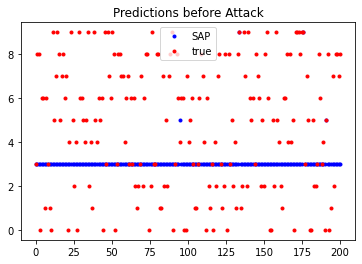

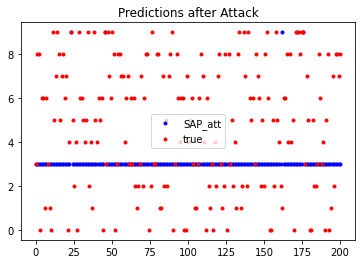

In [ ]:
x = np.linspace(0,200,200)
plt.plot(x,sap[:200],'b.',label="SAP")
plt.plot(x,ytrue[:200],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,sap_att[:200],'b.', label="SAP_att")
plt.plot(x,ytrue[:200],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

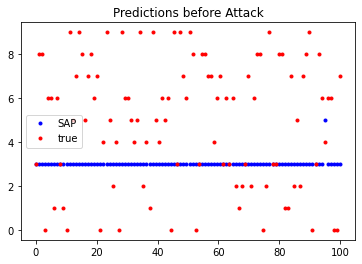

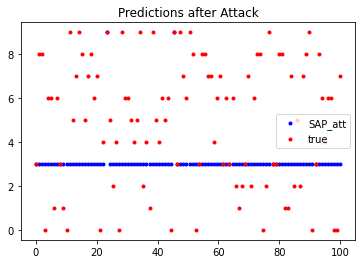

In [ ]:
x = np.linspace(0,100,100)
plt.plot(x,sap[:100],'b.',label="SAP")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,sap_att[:100],'b.', label="SAP_att")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

## free train

### Non SAP

In [41]:
# epsilons = 0.05
del pretrained_model
del pretrained_dict

"""Load Model"""
criterion = nn.CrossEntropyLoss()
modelpath = path + "ResNet18_19.pth"

pretrained_model = ResNet18().to(device)
pretrained_model.load_state_dict(torch.load(modelpath)['model_state_dict'])
pretrained_dict = pretrained_model.state_dict()
# pretrained_model

In [ ]:
# testattack(pretrained_model, attackloader, epsilons)

Epsilon: 0.05	Test Accuracy = 1564 / 10000 = 0.1564


0.1564

In [26]:
grey_box_attack(pretrained_model, attackloader)

0.1139

In [45]:
grey_box_attack(pretrained_model, attackloader)

0.5039

In [48]:
grey_box_attack(SAPmodel, attackloader)

0.4991

### Multi-SAP

In [ ]:
random_SAPmodel = ResNet18SAP().to(device)
model_dict = random_SAPmodel.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
random_SAPmodel.load_state_dict(pretrained_dict)
random_SAPmodel

ResNetSAP(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockSAP(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (sap1): SAP()
    )
    (1): BasicBlockSAP(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps

In [ ]:
norep_grad = get_grad(random_SAPmodel, attack_loader)
norep_grad

array([[[[-5.18804882e-03, -1.80723099e-03, -1.42200675e-04, ...,
          -1.30187417e-03, -7.16459064e-04,  1.26812910e-03],
         [-2.88091833e-03,  3.04207113e-03, -9.99704935e-03, ...,
           5.48704294e-04,  5.31387702e-03, -1.32073101e-03],
         [ 4.54224180e-04,  7.96772819e-03, -8.95711780e-03, ...,
           8.07577651e-03,  5.29757235e-04, -4.00464749e-04],
         ...,
         [-3.18535022e-04, -7.57885864e-04,  7.91372557e-04, ...,
          -1.98809407e-03,  1.21554511e-03,  7.43202982e-04],
         [ 1.95641536e-03,  4.47220198e-04, -3.95797309e-04, ...,
          -8.95681296e-06, -1.68874429e-03,  2.99600651e-04],
         [ 5.31528727e-04,  4.52570966e-04, -1.03245920e-03, ...,
           2.92239129e-04, -1.21033541e-03,  3.54233285e-04]],

        [[ 1.88240432e-03,  7.28463661e-03, -4.73057968e-04, ...,
          -2.12761550e-03,  1.00380229e-03,  2.84370338e-03],
         [ 4.34551574e-03,  1.59704722e-02, -1.76736887e-03, ...,
          -6.71528047e

In [ ]:
norep_grad.shape

(10000, 3, 32, 32)

In [ ]:
np.save("sap_grads.npy", norep_grad)

In [ ]:
def get_batch_grad(epoch, model, loader):
    for e in range(epoch):
        grad = get_grad(model, loader)
        np.save("sap_{}_grads.npy".format(e), grad)

In [ ]:
get_batch_grad(10, random_SAPmodel, attack_loader)

In [ ]:
!mv sap_0_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_1_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_2_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_3_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_4_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_5_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_6_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_7_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_8_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"
!mv sap_9_grads.npy "/content/gdrive/My Drive/GameTheory/cal_grad/"

In [ ]:
%cd /content/gdrive/My Drive/GameTheory/cal_grad/
!ls

/content/gdrive/My Drive/GameTheory/cal_grad


In [ ]:
!ls

sap_0_grads.npy  sap_3_grads.npy  sap_6_grads.npy  sap_9_grads.npy
sap_1_grads.npy  sap_4_grads.npy  sap_7_grads.npy
sap_2_grads.npy  sap_5_grads.npy  sap_8_grads.npy


In [ ]:
data_0 = np.load("sap_0_grads.npy")
data_1 = np.load("sap_1_grads.npy")
data_2 = np.load("sap_2_grads.npy")
data_3 = np.load("sap_3_grads.npy")
data_4 = np.load("sap_4_grads.npy")
data_5 = np.load("sap_5_grads.npy")
data_6 = np.load("sap_6_grads.npy")
data_7 = np.load("sap_7_grads.npy")
data_8 = np.load("sap_8_grads.npy")
data_9 = np.load("sap_9_grads.npy")

In [ ]:
pccs = np.corrcoef(data_0[0,0,:,:], data_1[0,0,:,:])
# data_0[0,0,:,:].shape
pccs.shape

(64, 64)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

value = cosine_similarity(data_0[0,0,:,:], data_1[0,0,:,:]).diagonal()
value

array([0.6226647 , 0.44118246, 0.52690274, 0.72838825, 0.76896256,
       0.6309645 , 0.726506  , 0.76260436, 0.619794  , 0.7580083 ,
       0.8095388 , 0.6519787 , 0.56531835, 0.7319704 , 0.81808114,
       0.7975999 , 0.80541646, 0.7155075 , 0.78109664, 0.8570281 ,
       0.716197  , 0.68790615, 0.6453944 , 0.60696006, 0.47915378,
       0.59217554, 0.46975082, 0.7243332 , 0.5614307 , 0.6576332 ,
       0.66668254, 0.39292344], dtype=float32)

In [ ]:
testattack(random_SAPmodel, attack_loader, 0.05)

KeyboardInterrupt: ignored

In [ ]:
acc,acc_sap,nonsap,nonsap_att,sap,sap_att,ytrue = testattackSAP(pretrained_model, random_SAPmodel, attack_loader, 0.05)


Time:  219.77641534805298
Epsilon: 0.05	Test Accuracy = 1564.0 / 10000 = 0.1564
Epsilon: 0.05	SAP Test Accuracy = 2537.0 / 10000 = 0.2537


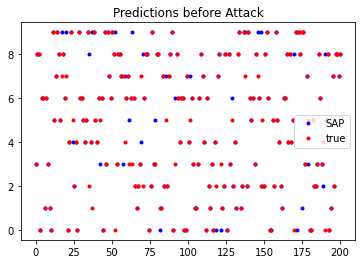

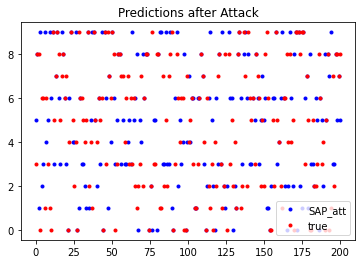

In [ ]:
x = np.linspace(0,200,200)
plt.plot(x,sap[:200],'b.',label="SAP")
plt.plot(x,ytrue[:200],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,sap_att[:200],'b.', label="SAP_att")
plt.plot(x,ytrue[:200],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

In [ ]:
acc,acc_sap,nonsap,nonsap_att,sap,sap_att,ytrue = testattackSAP(pretrained_model, random_SAPmodel, attack_loader, 0.05)


Time:  234.8245918750763
Epsilon: 0.05	Test Accuracy = 1564.0 / 10000 = 0.1564
Epsilon: 0.05	SAP Test Accuracy = 2549.0 / 10000 = 0.2549


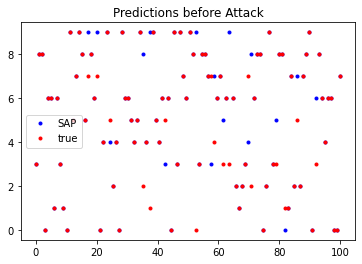

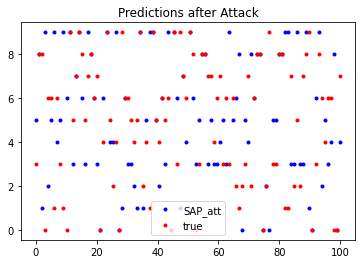

In [ ]:
# for i in range(10000):
#     print(sap[i],sap_att[i])

import matplotlib.pyplot as plt

# x = [1,2,3,4,5,6,7,8,9,10]
x = np.linspace(0,100,100)
plt.plot(x,sap[:100],'b.',label="SAP")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,sap_att[:100],'b.', label="SAP_att")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

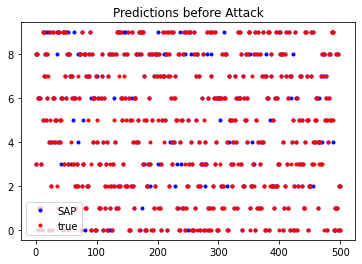

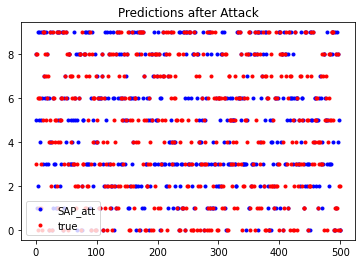

In [ ]:
x = np.linspace(0,500,500)
plt.plot(x,sap[:500],'b.',label="SAP")
plt.plot(x,ytrue[:500],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,sap_att[:500],'b.', label="SAP_att")
plt.plot(x,ytrue[:500],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

In [ ]:
testattack(random_SAPmodel, attack_loader, 0.05)

Epsilon: 0.05	Test Accuracy = 282 / 10000 = 0.0282


0.0282

In [ ]:
testattack(SAPmodel, attack_loader, 0.05)

Epsilon: 0.05	Test Accuracy = 277 / 10000 = 0.0277


0.0277

In [ ]:
acc,acc_sap,nonsap,nonsap_att,sap,sap_att,ytrue = testattackSAP(pretrained_model, random_SAPmodel, attack_loader, 0.05)

Time:  2590.345270395279
Epsilon: 0.05	Test Accuracy = 1564.0 / 10000 = 0.1564
Epsilon: 0.05	SAP Test Accuracy = 908.0 / 10000 = 0.0908


In [ ]:
sap

[array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([2]),
 array([3]),
 array([3]),
 array([5]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([2]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([2]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([2]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([2]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([2]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([5]),
 array([3]),
 array([3]),

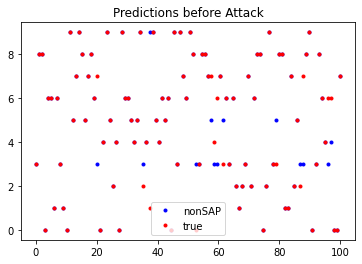

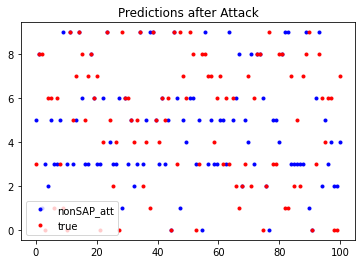

In [ ]:
import matplotlib.pyplot as plt

# x = [1,2,3,4,5,6,7,8,9,10]
x = np.linspace(0,100,100)
plt.plot(x,nonsap[:100],'b.',label="nonSAP")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions before Attack")
plt.show()

plt.plot(x,nonsap_att[:100],'b.', label="nonSAP_att")
plt.plot(x,ytrue[:100],'r.',label="true")
plt.legend() 
plt.title("Predictions after Attack")
plt.show()

# plt.plot(x,sap_att[:100],'b.', label="SAP_att")
# plt.plot(ytrue[:100],sap_att[:100],'r.',label="true")
# plt.legend() 
# plt.show()

In [ ]:
all_grad = []
all_pred = []
for inputs, targets in attackloader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    inputs.requires_grad = True

    # outputs = net(inputs)
    grad_list = []
    pred_list = []

    for i in range(10):
        start = time.time()

        outputs_sap = random_SAPmodel(inputs)
    # nonsap.append(outputs.detach().cpu().numpy())
    # sap.append(outputs_sap.detach().cpu().numpy())
    # print("[non sap]: ",outputs, "\n[sap]: ", outputs_sap, "\n")
    
    # _, predicted = outputs.max(1)
        _, predicted_sap = outputs_sap.max(1)
        pred_list.append(predicted_sap.detach().cpu().numpy())
    # if predicted.item() != targets.item():
    #     continue
    # loss = criterion(outputs, targets)
        loss_sap = criterion(outputs_sap, targets)

    # net.zero_grad()
        random_SAPmodel.zero_grad()

    # test_loss += loss.item()
    # loss.backward()
        loss_sap.backward()

    # pdb.set_trace()
        data_grad = inputs.grad.data

        grad_list.append(data_grad.detach().cpu().numpy())
        
        # print("Time: ", time.time()-start, data_grad.detach().cpu().numpy())

    grad_list = np.concatenate(grad_list)
    pred_list = np.concatenate(pred_list)

    print("Target: {}\nPredictions: {}".format(targets.detach().cpu().numpy(), pred_list))

    all_grad.append(grad_list)
    all_pred.append(pred_list)

Target: [3]
Predictions: [2 3 3 3 3 3 3 3 3 3]
Target: [8]
Predictions: [3 3 2 2 3 3 3 3 3 2]
Target: [8]
Predictions: [3 2 5 3 3 3 3 2 3 3]
Target: [0]
Predictions: [3 3 3 3 3 3 3 3 3 2]
Target: [6]
Predictions: [3 3 3 3 3 2 3 3 3 3]
Target: [6]
Predictions: [3 3 2 2 3 3 2 3 2 2]
Target: [1]
Predictions: [3 3 3 3 3 3 3 3 3 3]
Target: [6]
Predictions: [3 3 3 3 3 3 3 3 2 3]
Target: [3]
Predictions: [3 3 3 3 3 3 3 3 3 2]
Target: [1]
Predictions: [3 3 3 3 3 2 2 3 2 3]
Target: [0]
Predictions: [3 3 2 3 3 3 3 3 3 3]
Target: [9]
Predictions: [3 3 3 3 3 3 3 3 3 3]
Target: [5]
Predictions: [5 3 5 5 5 5 3 3 3 5]
Target: [7]
Predictions: [3 3 3 5 5 3 5 3 3 3]
Target: [9]
Predictions: [3 3 3 3 2 3 3 3 3 3]
Target: [8]
Predictions: [3 3 3 3 5 3 3 3 3 3]
Target: [5]
Predictions: [5 3 5 3 2 3 3 5 5 3]
Target: [7]
Predictions: [3 3 3 3 3 3 3 3 3 3]
Target: [8]
Predictions: [3 3 3 3 5 3 3 3 3 5]
Target: [6]
Predictions: [2 3 3 5 3 3 3 2 3 3]
Target: [7]
Predictions: [3 3 3 3 3 3 3 5 3 3]
Target: [0]
P

KeyboardInterrupt: ignored

In [ ]:
all_grad = []
all_pred = []
for inputs, targets in attackloader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    inputs.requires_grad = True

    # outputs = net(inputs)
    grad_list = []
    pred_list = []

    for i in range(10):
        start = time.time()

        outputs_sap = SAPmodel(inputs)
    # nonsap.append(outputs.detach().cpu().numpy())
    # sap.append(outputs_sap.detach().cpu().numpy())
    # print("[non sap]: ",outputs, "\n[sap]: ", outputs_sap, "\n")
    
    # _, predicted = outputs.max(1)
        _, predicted_sap = outputs_sap.max(1)
        pred_list.append(predicted_sap.detach().cpu().numpy())
    # if predicted.item() != targets.item():
    #     continue
    # loss = criterion(outputs, targets)
        loss_sap = criterion(outputs_sap, targets)

    # net.zero_grad()
        SAPmodel.zero_grad()

    # test_loss += loss.item()
    # loss.backward()
        loss_sap.backward()

    # pdb.set_trace()
        data_grad = inputs.grad.data

        grad_list.append(data_grad.detach().cpu().numpy())
        
        # print("Time: ", time.time()-start, data_grad.detach().cpu().numpy())

    grad_list = np.concatenate(grad_list)
    pred_list = np.concatenate(pred_list)

    print("Time: ", time.time()-start, pred_list)

    all_grad.append(grad_list)
    all_pred.append(pred_list)


Time:  0.13634538650512695 [3 3 3 3 3 3 3 3 3 3]
Time:  0.1356961727142334 [8 8 8 8 8 8 8 8 8 8]
Time:  0.13714838027954102 [8 8 8 8 8 8 8 8 8 8]
Time:  0.13504409790039062 [0 0 0 0 0 0 0 0 0 0]
Time:  0.13698196411132812 [6 6 6 6 6 6 6 6 6 6]
Time:  0.13414907455444336 [6 6 6 6 6 6 6 6 6 6]
Time:  0.14013385772705078 [1 1 1 1 1 1 1 1 1 1]
Time:  0.13685274124145508 [6 6 6 6 4 4 6 4 6 6]
Time:  0.1355290412902832 [3 3 3 3 3 3 3 3 3 3]
Time:  0.14136719703674316 [1 1 1 1 1 1 1 1 1 1]
Time:  0.14125323295593262 [0 0 0 0 0 0 0 0 0 0]
Time:  0.1413428783416748 [9 9 9 9 9 9 9 9 9 9]
Time:  0.14101481437683105 [5 5 5 5 5 5 5 5 5 5]
Time:  0.136704683303833 [7 7 7 7 7 7 7 7 7 7]
Time:  0.1419084072113037 [9 9 9 9 9 9 9 9 9 9]
Time:  0.13812828063964844 [8 8 8 8 8 8 8 8 8 8]
Time:  0.1367170810699463 [5 5 5 5 5 5 5 5 5 5]
Time:  0.13896393775939941 [7 7 7 7 7 7 7 7 7 7]
Time:  0.13330817222595215 [8 8 8 8 8 8 8 8 8 8]
Time:  0.13672447204589844 [6 6 6 6 6 6 6 6 6 6]
Time:  0.13536691665649414 

KeyboardInterrupt: ignored

### SAP

In [46]:
import gc

# del pretrained_model
del SAPmodel
del model_dict
# del adv_SAPmodel
# del random_SAPmodel

gc.collect()

torch.cuda.empty_cache()

In [47]:
SAPmodel = ResNet18SAP().to(device)
model_dict = SAPmodel.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
SAPmodel.load_state_dict(pretrained_dict)
# SAPmodel

<All keys matched successfully>

In [ ]:
testattack(SAPmodel, attackloader, epsilons)

Epsilon: 0.05	Test Accuracy = 2352 / 10000 = 0.2352


0.2352

In [ ]:
acc,nonsap,sap = testattackSAP(pretrained_model, SAPmodel, attackloader, epsilons)

Time:  3339.825381040573
Epsilon: 0.05	Test Accuracy = 1759.0 / 10000 = 0.1759
Epsilon: 0.05	SAP Test Accuracy = 2320.0 / 10000 = 0.232


In [ ]:
len(nonsap)

10000

In [ ]:
ns = np.squeeze(np.array(nonsap))
s = np.squeeze(np.array(sap))

ns_T = ns.T
s_T = s.T

In [ ]:
ns

array([[-3.8903615 , -1.1280159 ,  0.23229028, ..., -4.1752434 ,
        -4.848581  , -2.5983932 ],
       [ 4.819295  ,  7.241415  , -6.026654  , ..., -8.699162  ,
        21.03437   ,  6.018537  ],
       [-0.98606944,  5.3888817 , -3.0065365 , ..., -1.7793741 ,
         9.170575  ,  2.4320157 ],
       ...,
       [-4.086999  , -7.1385303 ,  4.495023  , ..., -0.37989378,
        -4.7056193 , -6.6373334 ],
       [-1.3558166 ,  9.744921  ,  0.75933   , ..., -5.096431  ,
        -4.56338   ,  0.64443576],
       [-5.8278155 , -3.3253186 , -1.7788514 , ..., 17.581259  ,
        -5.801214  , -5.08792   ]], dtype=float32)

In [ ]:
ns_T = ns.T
ns_T[0].shape

(10000,)

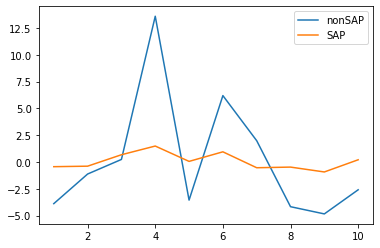

In [ ]:
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,ns[0],label="nonSAP")
plt.plot(x,s[0],label="SAP")
plt.legend() 

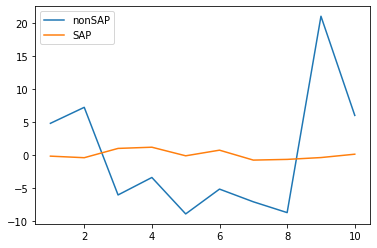

In [ ]:
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,ns[1],label="nonSAP")
plt.plot(x,s[1],label="SAP")
plt.legend()

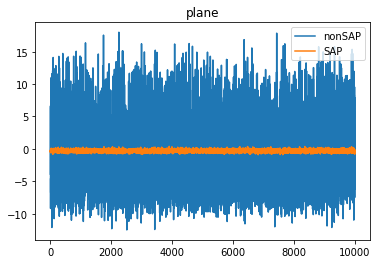

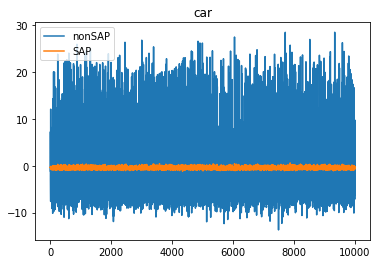

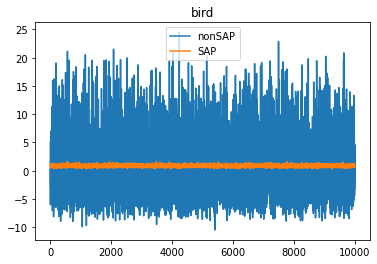

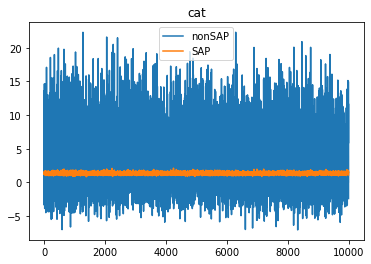

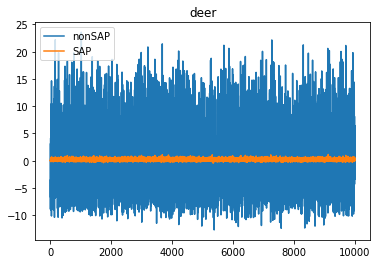

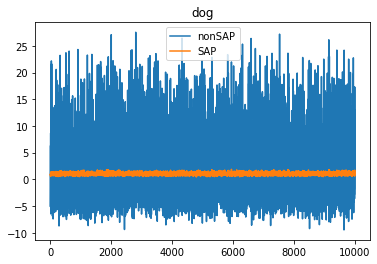

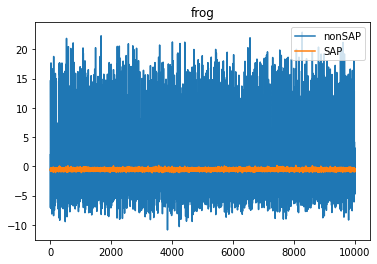

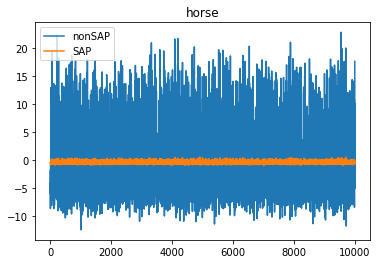

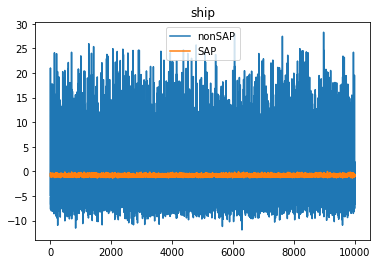

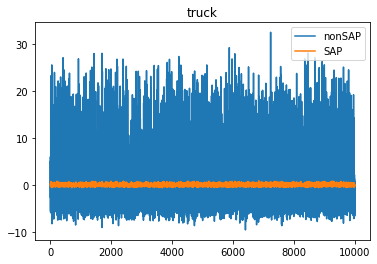

In [ ]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

x = np.linspace(0,10000,10000)

for i in range(len(classes)):
    plt.plot(x,ns_T[i],label="nonSAP")
    plt.plot(x,s_T[i],label="SAP")
    plt.legend()
    plt.title(classes[i])
    plt.show()